In [1]:
import pandas as pd
from functions.processing_data_functions import standardize_death_types, calculate_age_specific_rates

# Load the Excel file
file_path = "Data/deaths_in_custody_by_prison.xlsx" # extracte from the Deaths data tool

# Read the Excel file into a Pandas DataFrame
data = pd.read_excel(file_path)

# Standardize column names for ease of use
data.columns = [col.strip().lower().replace(" ", "_") for col in data.columns]

In [2]:
# Apply the standardization
data = standardize_death_types(data)

# Verify the unique values
print(data.type_of_death.unique())

['Natural Causes' 'Self-Inflicted' 'Other' 'Homicide']


In [3]:
# Generate separate dataframes for specific causes
# Collapse deaths grouped by prison and date, removing age_band from grouping
all_causes = (
    data.groupby(["prison", "date"])
    .agg({"incidents": "sum"})
    .reset_index()
)

natural_causes = data[
    data["type_of_death"].str.contains("natural", case=False, na=False)
].groupby(["prison", "date"]).agg({"incidents": "sum"}).reset_index()

self_inflicted = data[
    data["type_of_death"].str.contains("self-inflicted", case=False, na=False)
].groupby(["prison", "date"]).agg({"incidents": "sum"}).reset_index()

homicides = data[
    data["type_of_death"].str.contains("homicide", case=False, na=False)
].groupby(["prison", "date"]).agg({"incidents": "sum"}).reset_index()

other_causes = data[
    ~data["type_of_death"].str.contains("natural|self-inflicted|homicide", case=False, na=False)
].groupby(["prison", "date"]).agg({"incidents": "sum"}).reset_index()

# Display the structure and a few rows of each dataframe
print("Collapsed deaths grouped by prison and date:")
print(all_causes.head())

print("Natural causes grouped by prison and date:")
print(natural_causes.head())

print("Self-inflicted deaths grouped by prison and date:")
print(self_inflicted.head())

print("Homicides grouped by prison and date:")
print(homicides.head())

print("Other causes grouped by prison and date:")
print(other_causes.head())

# Save the dataframes for future use
all_causes.to_csv("Output/Deaths/collapsed_deaths_by_prison_date.csv", index=False)
natural_causes.to_csv("Output/Deaths/natural_causes_by_prison_date.csv", index=False)
self_inflicted.to_csv("Output/Deaths/self_inflicted_by_prison_date.csv", index=False)
homicides.to_csv("Output/Deaths/homicides_by_prison_date.csv", index=False)
other_causes.to_csv("Output/Deaths/other_causes_by_prison_date.csv", index=False)


Collapsed deaths grouped by prison and date:
      prison       date  incidents
0  Altcourse 2001-03-01          1
1  Altcourse 2001-05-01          1
2  Altcourse 2001-09-01          1
3  Altcourse 2002-05-01          1
4  Altcourse 2002-07-01          1
Natural causes grouped by prison and date:
      prison       date  incidents
0  Altcourse 2001-03-01          1
1  Altcourse 2001-05-01          1
2  Altcourse 2001-09-01          1
3  Altcourse 2002-05-01          1
4  Altcourse 2003-08-01          1
Self-inflicted deaths grouped by prison and date:
      prison       date  incidents
0  Altcourse 2002-07-01          1
1  Altcourse 2003-07-01          1
2  Altcourse 2003-12-01          1
3  Altcourse 2005-02-01          1
4  Altcourse 2005-07-01          3
Homicides grouped by prison and date:
       prison       date  incidents
0   Altcourse 2014-11-01          1
1    Belmarsh 2020-02-01          1
2  Birmingham 2000-10-01          1
3  Birmingham 2022-10-01          1
4   Brinsford 

C:\Users\Denis\AppData\Local\Temp\ipykernel_51912\270922445.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_deaths = df.groupby(pd.Grouper(key='date', freq='M'))['incidents'].sum().reset_index()


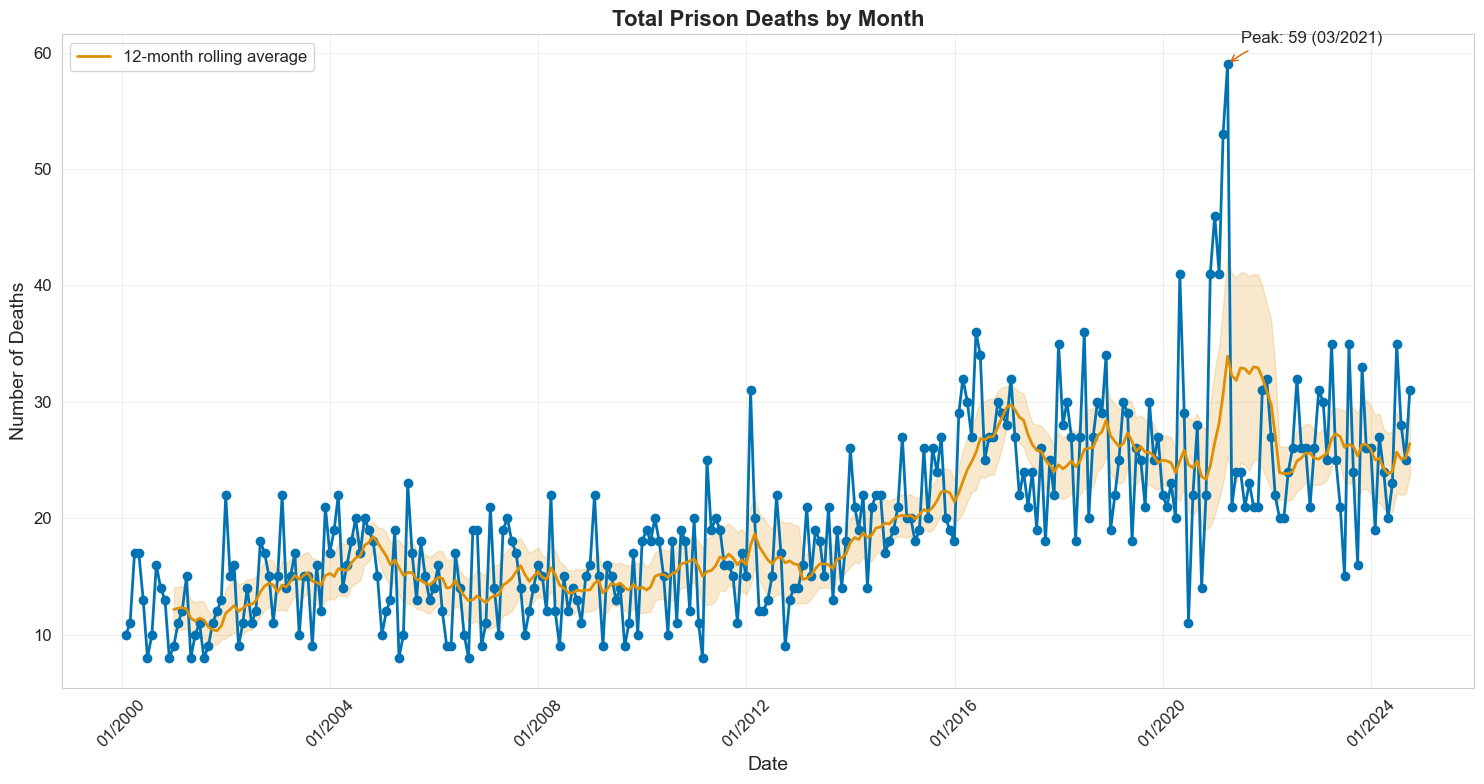

C:\Users\Denis\AppData\Local\Temp\ipykernel_51912\270922445.py:84: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_deaths = df.groupby(pd.Grouper(key='date', freq='Q'))['incidents'].sum()


Quarterly statistics:
count     99.000000
mean      58.535354
std       20.244079
min       28.000000
25%       42.000000
50%       55.000000
75%       73.500000
max      153.000000
Name: incidents, dtype: float64

Yearly statistics:
count     25.00000
mean     231.80000
std       70.22464
min      142.00000
25%      175.00000
50%      208.00000
75%      300.00000
max      371.00000
Name: incidents, dtype: float64


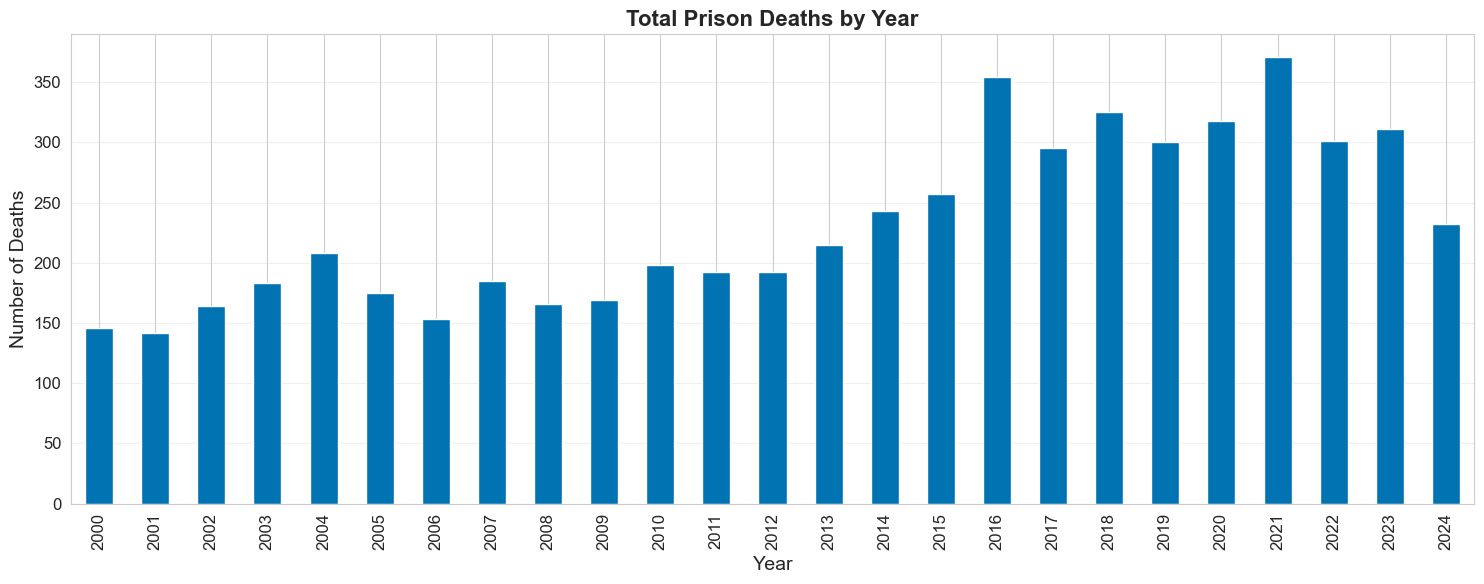

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# Set style for better visualizations with colorblind-friendly palette
sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 12})
# Use a colorblind-friendly palette
# Using the 'colorblind' palette from seaborn
colors = sns.color_palette("colorblind")

# Read the data
file_path = 'Output/Deaths/collapsed_deaths_by_prison_date.csv'
df = pd.read_csv(file_path)

# Convert the date column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Group by month and sum incidents
# First create a monthly date series
monthly_deaths = df.groupby(pd.Grouper(key='date', freq='M'))['incidents'].sum().reset_index()

# Create a time series plot
plt.figure(figsize=(15, 8))
plt.plot(monthly_deaths['date'], monthly_deaths['incidents'], marker='o', linestyle='-', color=colors[0], linewidth=2)

# Add a trend line using rolling mean with 95% CI
window_size = 12
rolling_mean = monthly_deaths['incidents'].rolling(window=window_size).mean()

# Calculate the standard error for the rolling mean
rolling_std = monthly_deaths['incidents'].rolling(window=window_size).std()
rolling_se = rolling_std / np.sqrt(window_size)

# Calculate 95% confidence interval
conf_interval = 1.96 * rolling_se  # 1.96 is the z-score for 95% confidence

# Plot rolling mean and confidence interval
plt.plot(monthly_deaths['date'], rolling_mean, color=colors[1], linewidth=2, label='12-month rolling average')
plt.fill_between(monthly_deaths['date'], 
                 rolling_mean - conf_interval, 
                 rolling_mean + conf_interval, 
                 color=colors[1], alpha=0.2)

# Calculate yearly totals for statistics only
yearly_deaths = df.groupby(df['date'].dt.year)['incidents'].sum()

# Add title and labels
plt.title('Total Prison Deaths by Month', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Deaths', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()

# Rotate x-axis labels for better readability and format them as numeric
plt.xticks(rotation=45)

# Format the x-axis date labels to use numeric month format (MM/YYYY)
import matplotlib.dates as mdates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))

# Adjust layout
plt.tight_layout()

# Add annotation only for the highest peak
highest_peak = monthly_deaths.nlargest(1, 'incidents').iloc[0]
# Format date as numeric month and year (e.g., "01/2005" for January 2005)
month_year = highest_peak['date'].strftime('%m/%Y')
plt.annotate(f"Peak: {highest_peak['incidents']} ({month_year})",
            xy=(highest_peak['date'], highest_peak['incidents']),
            xytext=(10, 15),
            textcoords='offset points',
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2', color=colors[3]))

# Save the figure
plt.savefig('Output/Deaths/prison_deaths_over_time.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

# Additional analysis: Calculate quarterly and yearly statistics
quarterly_deaths = df.groupby(pd.Grouper(key='date', freq='Q'))['incidents'].sum()
print("Quarterly statistics:")
print(quarterly_deaths.describe())

print("\nYearly statistics:")
print(yearly_deaths.describe())

# Create a bar chart of yearly deaths
plt.figure(figsize=(15, 6))
yearly_deaths.plot(kind='bar', color=colors[0])
plt.title('Total Prison Deaths by Year', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Deaths', fontsize=14)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('Output/Deaths/prison_deaths_yearly.png', dpi=300, bbox_inches='tight')
plt.show()

### Calculating the population by age for years 2002-2024
Source https://commonslibrary.parliament.uk/research-briefings/sn04334/

In [5]:
import pandas as pd

# Create the DataFrame directly from the data
df = {
    'Year': ['2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', 
             '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021',
             '2022', '2023', '2024'],
    'Age_15_20': [10923, 10199, 10011, 10138, 10443, 11045, 11352, 10892, 10234, 9508,
                  8725, 7138, 6442, 5730, 5194, 5219, 4883, 4770, 4068, 3883,
                  3573, 3625, 3354],
    'Age_21_29': [26710, 27584, 27359, 27273, 27512, 27843, 29222, 29386, 29960, 29538,
                  29580, 28217, 28609, 28027, 26758, 26020, 24333, 23918, 22371, 21530,
                  21301, 21590, 21381],
    'Age_30_39': [20391, 21654, 21877, 22007, 21960, 21413, 22073, 21699, 22220, 22740,
                  22900, 23248, 24361, 25075, 25189, 25894, 25310, 25745, 25307, 25211, 
                  26446, 28524, 29339],
    'Age_40_49': [8371, 9210, 9973, 11068, 11881, 12638, 13400, 13866, 14325, 14645,
                  15116, 15008, 15017, 15381, 15283, 15354, 14631, 14660, 14497, 14569,
                  15504, 17174, 18175],
    'Age_50+': [4824, 5010, 5268, 5704, 6186, 6795, 7147, 7548, 8263, 8943,
               9727, 10231, 11080, 11980, 12710, 13376, 13616, 13617, 13271, 13131,
               13835, 14938, 15620],
    'Total': [71218, 73657, 74488, 76190, 77982, 79734, 83194, 83391, 85002, 85374,
             86048, 83842, 85509, 86193, 85134, 85863, 82773, 82710, 79514, 78324,
             80659, 85851, 87869]
}

# Create the DataFrame
prison_df = pd.DataFrame(df)

# Add columns for proportions of each age group
age_columns = ['Age_15_20', 'Age_21_29', 'Age_30_39', 'Age_40_49', 'Age_50+']

# Calculate proportions and add to DataFrame
for age_col in age_columns:
    prop_col_name = f'Prop_{age_col}'
    prison_df[prop_col_name] = prison_df[age_col] / prison_df['Total']
    # Format as percentage (optional)
    prison_df[prop_col_name] = prison_df[prop_col_name].round(4)  # Round to 4 decimal places (0.1234 = 12.34%)

# Display the first few rows with the new proportion columns
print(prison_df.head())

# Save to CSV if needed
prison_df.to_csv('Data/prison_population_with_proportions.csv', index=False)

   Year  Age_15_20  Age_21_29  Age_30_39  Age_40_49  Age_50+  Total  \
0  2002      10923      26710      20391       8371     4824  71218   
1  2003      10199      27584      21654       9210     5010  73657   
2  2004      10011      27359      21877       9973     5268  74488   
3  2005      10138      27273      22007      11068     5704  76190   
4  2006      10443      27512      21960      11881     6186  77982   

   Prop_Age_15_20  Prop_Age_21_29  Prop_Age_30_39  Prop_Age_40_49  \
0          0.1534          0.3750          0.2863          0.1175   
1          0.1385          0.3745          0.2940          0.1250   
2          0.1344          0.3673          0.2937          0.1339   
3          0.1331          0.3580          0.2888          0.1453   
4          0.1339          0.3528          0.2816          0.1524   

   Prop_Age_50+  
0        0.0677  
1        0.0680  
2        0.0707  
3        0.0749  
4        0.0793  


In [6]:
prison_df

,Year,Age_15_20,Age_21_29,Age_30_39,Age_40_49,Age_50+,Total,Prop_Age_15_20,Prop_Age_21_29,Prop_Age_30_39,Prop_Age_40_49,Prop_Age_50+
0,2002,10923,26710,20391,8371,4824,71218,0.1534,0.3750,0.2863,0.1175,0.0677
1,2003,10199,27584,21654,9210,5010,73657,0.1385,0.3745,0.2940,0.1250,0.0680
2,2004,10011,27359,21877,9973,5268,74488,0.1344,0.3673,0.2937,0.1339,0.0707
3,2005,10138,27273,22007,11068,5704,76190,0.1331,0.3580,0.2888,0.1453,0.0749
4,2006,10443,27512,21960,11881,6186,77982,0.1339,0.3528,0.2816,0.1524,0.0793
5,2007,11045,27843,21413,12638,6795,79734,0.1385,0.3492,0.2686,0.1585,0.0852
6,2008,11352,29222,22073,13400,7147,83194,0.1365,0.3513,0.2653,0.1611,0.0859
7,2009,10892,29386,21699,13866,7548,83391,0.1306,0.3524,0.2602,0.1663,0.0905
8,2010,10234,29960,22220,14325,8263,85002,0.1204,0.3525,0.2614,0.1685,0.0972
9,2011,9508,29538,22740,14645,8943,85374,0.1114,0.3460,0.2664,0.1715,0.1048


### Extracting data for causes of death per age

In [7]:
import pandas as pd

# Group the data by year and type_of_death
deaths_by_cause = data.groupby(['year', 'type_of_death']).agg(
    total_deaths=('incidents', 'sum')
).reset_index()

# Pivot the data to have years as rows and causes of death as columns
deaths_yearly = deaths_by_cause.pivot_table(
    index='year',
    columns='type_of_death',
    values='total_deaths',
    fill_value=0
).reset_index()

# Make sure column names are properly formatted
deaths_yearly.columns.name = None

# Add a total column
cause_columns = [col for col in deaths_yearly.columns if col != 'year']
deaths_yearly['Total'] = deaths_yearly[cause_columns].sum(axis=1)

# Sort by year
deaths_yearly = deaths_yearly.sort_values('year')

# Print the first few rows
print("Deaths by Year and Cause:")
print(deaths_yearly.head())

# Save to CSV
deaths_yearly.to_csv('Output/Deaths/prison_deaths_yearly.csv', index=False)

Deaths by Year and Cause:
   year  Homicide  Natural Causes  Other  Self-Inflicted  Total
0  2000       3.0            61.0    1.0            81.0  146.0
1  2001       0.0            68.0    1.0            73.0  142.0
2  2002       0.0            66.0    3.0            95.0  164.0
3  2003       1.0            86.0    1.0            95.0  183.0
4  2004       2.0           101.0    9.0            96.0  208.0


In [8]:
# Convert 'Year' column in prison_df to numeric for proper merging
# Handle the '2024 (March)' special case
prison_df['Year_numeric'] = prison_df['Year'].apply(lambda x: int(x.split()[0]))

# Assuming deaths_yearly is already created from your previous code
# If not, you would have already processed it using your code

# Now perform the left join
# Note: We're assuming the 'year' column in deaths_yearly is already numeric
merged_df = pd.merge(
    prison_df,
    deaths_yearly,
    left_on='Year_numeric',
    right_on='year',
    how='left'
)

In [9]:
print(merged_df.head())

   Year  Age_15_20  Age_21_29  Age_30_39  Age_40_49  Age_50+  Total_x  \
0  2002      10923      26710      20391       8371     4824    71218   
1  2003      10199      27584      21654       9210     5010    73657   
2  2004      10011      27359      21877       9973     5268    74488   
3  2005      10138      27273      22007      11068     5704    76190   
4  2006      10443      27512      21960      11881     6186    77982   

   Prop_Age_15_20  Prop_Age_21_29  Prop_Age_30_39  Prop_Age_40_49  \
0          0.1534          0.3750          0.2863          0.1175   
1          0.1385          0.3745          0.2940          0.1250   
2          0.1344          0.3673          0.2937          0.1339   
3          0.1331          0.3580          0.2888          0.1453   
4          0.1339          0.3528          0.2816          0.1524   

   Prop_Age_50+  Year_numeric  year  Homicide  Natural Causes  Other  \
0        0.0677          2002  2002       0.0            66.0    3.0   
1 

### Additionally grouping by age band

In [11]:
import pandas as pd

# Group the data by year, age_band, and type_of_death
deaths_by_age_cause = data.groupby(['year', 'age_band', 'type_of_death']).agg(
    total_deaths=('incidents', 'sum')
).reset_index()

# Pivot the data to have year and age_band as rows and causes of death as columns
deaths_age_yearly = deaths_by_age_cause.pivot_table(
    index=['year', 'age_band'],
    columns='type_of_death',
    values='total_deaths',
    fill_value=0
).reset_index()

# Make sure column names are properly formatted
deaths_age_yearly.columns.name = None

# Add a total column
cause_columns = [col for col in deaths_age_yearly.columns if col not in ['year', 'age_band']]
deaths_age_yearly['Total'] = deaths_age_yearly[cause_columns].sum(axis=1)

# Sort by year and age_band
deaths_age_yearly = deaths_age_yearly.sort_values(['year', 'age_band'])

# Print the first few rows
print("Deaths by Year, Age Band, and Cause:")
print(deaths_age_yearly.head())

# Save to CSV
deaths_age_yearly.to_csv('Output/Deaths/prison_deaths_age_yearly.csv', index=False)

# Optional: Create a version with just the totals by age band for each year
deaths_by_age_year = data.groupby(['year', 'age_band']).agg(
    total_deaths=('incidents', 'sum')
).reset_index()

deaths_by_age_year_pivot = deaths_by_age_year.pivot_table(
    index='year',
    columns='age_band',
    values='total_deaths',
    fill_value=0
).reset_index()

deaths_by_age_year_pivot.columns.name = None

# Add a total column for all age bands
age_columns = [col for col in deaths_by_age_year_pivot.columns if col != 'year']
deaths_by_age_year_pivot['Total'] = deaths_by_age_year_pivot[age_columns].sum(axis=1)

# Sort by year
deaths_by_age_year_pivot = deaths_by_age_year_pivot.sort_values('year')

print("\nTotal Deaths by Year and Age Band:")
print(deaths_by_age_year_pivot.head())

# Save to CSV
deaths_by_age_year_pivot.to_csv('Output/Deaths/prison_deaths_by_age_year.csv', index=False)

Deaths by Year, Age Band, and Cause:
   year  age_band  Homicide  Natural Causes  Other  Self-Inflicted  Total
0  2000  15 to 17       0.0             0.0    0.0             3.0    3.0
1  2000  18 to 20       1.0             0.0    0.0            13.0   14.0
2  2000  21 to 24       1.0             0.0    0.0            13.0   14.0
3  2000  25 to 29       0.0             4.0    0.0            13.0   17.0
4  2000  30 to 39       1.0             7.0    1.0            26.0   35.0

Total Deaths by Year and Age Band:
   year  15 to 17  18 to 20  21 to 24  25 to 29  30 to 39  40 to 49  50 to 59  \
0  2000       3.0      14.0      14.0      17.0      35.0      20.0      16.0   
1  2001       3.0      10.0      14.0      14.0      31.0      25.0      16.0   
2  2002       2.0      12.0      15.0      21.0      36.0      30.0      24.0   
3  2003       0.0      12.0      17.0      19.0      44.0      29.0      25.0   
4  2004       0.0       7.0      14.0      22.0      49.0      36.0      34.0 

### Analyse by cause of deaths and age

In [12]:
print(data.head())
print(prison_df.head())

        date  year  month     prison   type_of_death  age_band  incidents
0 2001-03-01  2001      3  Altcourse  Natural Causes  30 to 39          1
1 2001-05-01  2001      5  Altcourse  Natural Causes  40 to 49          1
2 2001-09-01  2001      9  Altcourse  Natural Causes  40 to 49          1
3 2002-05-01  2002      5  Altcourse  Natural Causes  40 to 49          1
4 2002-07-01  2002      7  Altcourse  Self-Inflicted  40 to 49          1
   Year  Age_15_20  Age_21_29  Age_30_39  Age_40_49  Age_50+  Total  \
0  2002      10923      26710      20391       8371     4824  71218   
1  2003      10199      27584      21654       9210     5010  73657   
2  2004      10011      27359      21877       9973     5268  74488   
3  2005      10138      27273      22007      11068     5704  76190   
4  2006      10443      27512      21960      11881     6186  77982   

   Prop_Age_15_20  Prop_Age_21_29  Prop_Age_30_39  Prop_Age_40_49  \
0          0.1534          0.3750          0.2863          0

Age-specific death rates per 1000 prisoners:
    year age_category  cause_of_death  deaths  population  rate_per_1000
0   2002    Age_15_20  Natural Causes       1       10923       0.091550
1   2002    Age_15_20  Self-Inflicted      11       10923       1.007049
2   2002    Age_15_20           Other       0       10923       0.000000
3   2002    Age_15_20        Homicide       0       10923       0.000000
4   2002    Age_21_29  Natural Causes       5       26710       0.187196
5   2002    Age_21_29  Self-Inflicted      30       26710       1.123175
6   2002    Age_21_29           Other       1       26710       0.037439
7   2002    Age_21_29        Homicide       0       26710       0.000000
8   2002    Age_30_39  Natural Causes       6       20391       0.294247
9   2002    Age_30_39  Self-Inflicted      29       20391       1.422196
10  2002    Age_30_39           Other       1       20391       0.049041
11  2002    Age_30_39        Homicide       0       20391       0.000000
12  20

C:\Users\Denis\AppData\Local\Temp\ipykernel_51912\1293312193.py:68: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  overall_rates = age_specific_rates.groupby(['year', 'cause_of_death']).apply(


Analysis complete. Results saved to Ouput/Deaths/ directory.


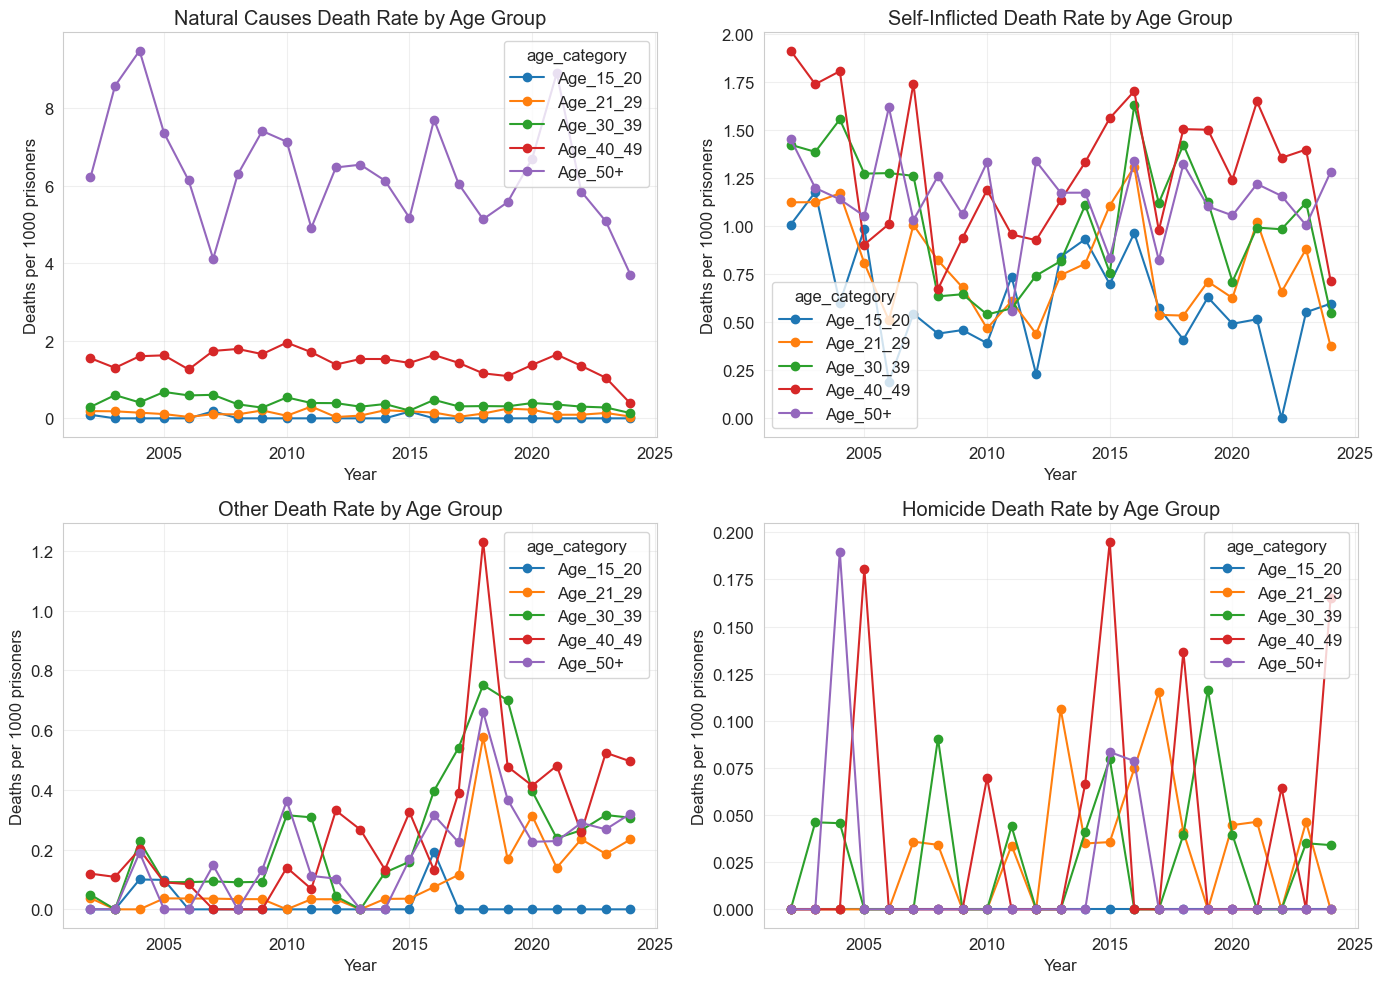

<Figure size 1000x600 with 0 Axes>

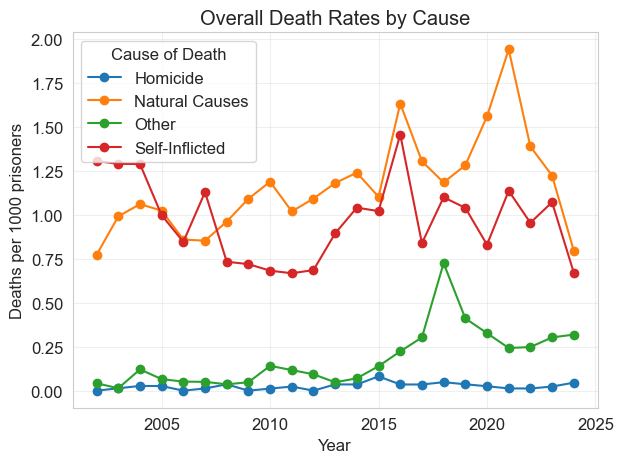

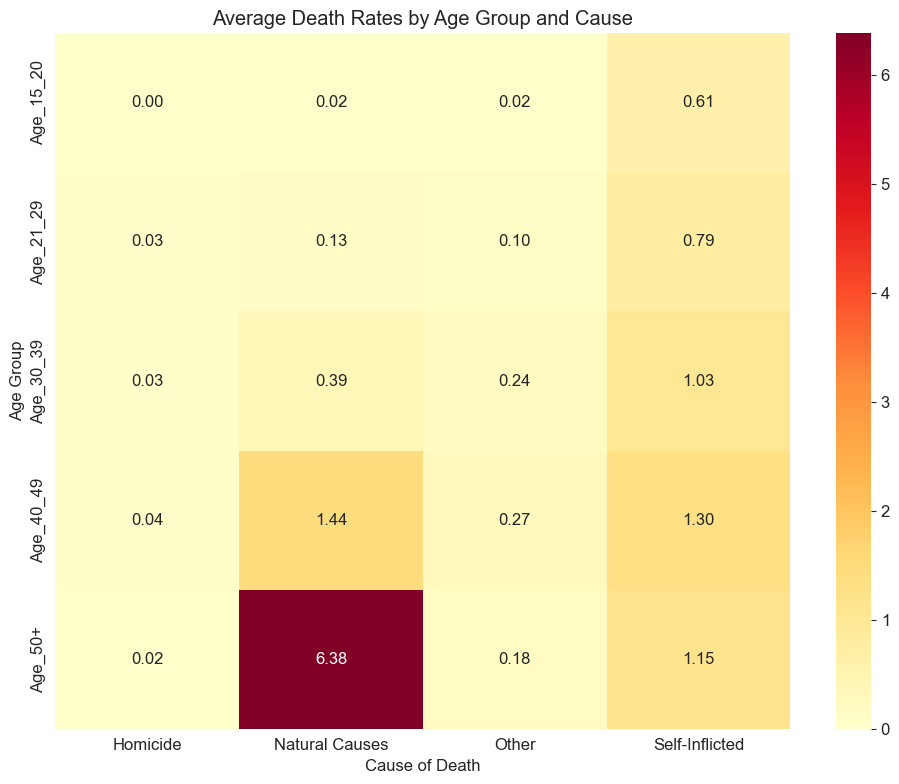

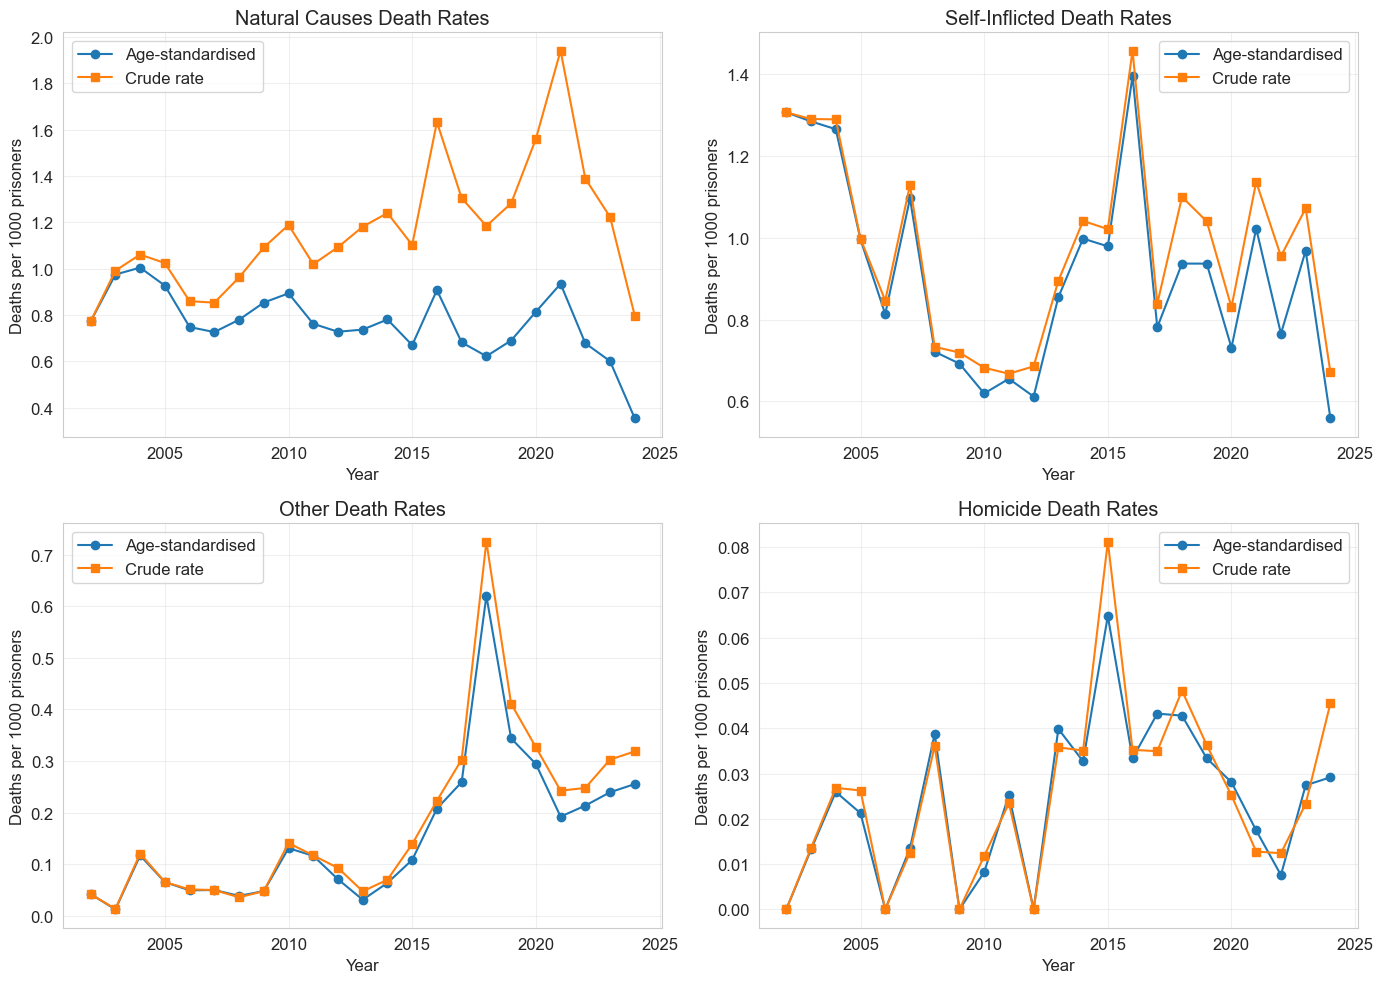

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# First, we need to map the age bands in 'data' to match the age categories in 'prison_df'
# Create a mapping dictionary
age_mapping = {
    'under 21': 'Age_15_20',
    '18 to 20': 'Age_15_20',  # If there are more specific categories in your data
    '21 to 24': 'Age_21_29',
    '25 to 29': 'Age_21_29',
    '30 to 39': 'Age_30_39',
    '40 to 49': 'Age_40_49',
    '50 to 59': 'Age_50+',
    '60 to 69': 'Age_50+',
    '70+': 'Age_50+',
    '70 and over': 'Age_50+'
}

# Add a standardized age category to the deaths data
data['age_category'] = data['age_band'].map(age_mapping)

# Group deaths by year, standardized age category, and type of death
deaths_by_age = data.groupby(['year', 'age_category', 'type_of_death']).agg(
    total_deaths=('incidents', 'sum')
).reset_index()

# Filter out any rows with NaN in age_category (in case some age bands didn't match)
deaths_by_age = deaths_by_age.dropna(subset=['age_category'])


# Calculate age-specific death rates
age_specific_rates = calculate_age_specific_rates(deaths_by_age, prison_df)

# Display some results
print("Age-specific death rates per 1000 prisoners:")
print(age_specific_rates.head(20))

# Create visualizations

# 1. Death rates by age group and cause over time
plt.figure(figsize=(14, 10))

for i, cause in enumerate(['Natural Causes', 'Self-Inflicted', 'Other', 'Homicide']):
    plt.subplot(2, 2, i+1)
    
    # Filter data for this cause
    cause_data = age_specific_rates[age_specific_rates['cause_of_death'] == cause]
    
    # Pivot for plotting
    pivot_data = cause_data.pivot(index='year', columns='age_category', values='rate_per_1000')
    
    # Plot
    pivot_data.plot(marker='o', ax=plt.gca())
    plt.title(f'{cause} Death Rate by Age Group')
    plt.ylabel('Deaths per 1000 prisoners')
    plt.xlabel('Year')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('Data/death_rates_by_age_cause.png', dpi=300)

# 2. Overall trends in death rates by cause
plt.figure(figsize=(10, 6))

# Calculate overall rates by cause and year
overall_rates = age_specific_rates.groupby(['year', 'cause_of_death']).apply(
    lambda x: (x['deaths'].sum() / x['population'].sum()) * 1000
).reset_index(name='overall_rate')

# Pivot for plotting
overall_pivot = overall_rates.pivot(index='year', columns='cause_of_death', values='overall_rate')

# Plot
overall_pivot.plot(marker='o')
plt.title('Overall Death Rates by Cause')
plt.ylabel('Deaths per 1000 prisoners')
plt.xlabel('Year')
plt.grid(True, alpha=0.3)
plt.legend(title='Cause of Death')

plt.tight_layout()
plt.savefig('Data/overall_death_rates.png', dpi=300)

# 3. Heatmap of death rates by age and cause (averaged across years)
plt.figure(figsize=(10, 8))

# Calculate average rates across years
avg_rates = age_specific_rates.groupby(['age_category', 'cause_of_death'])['rate_per_1000'].mean().reset_index()

# Pivot for heatmap
heatmap_data = avg_rates.pivot(index='age_category', columns='cause_of_death', values='rate_per_1000')

# Plot heatmap
sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='YlOrRd')
plt.title('Average Death Rates by Age Group and Cause')
plt.ylabel('Age Group')
plt.xlabel('Cause of Death')

plt.tight_layout()
plt.savefig('Data/death_rates_heatmap.png', dpi=300)

# Save the detailed results to CSV
age_specific_rates.to_csv('Data/age_specific_death_rates.csv', index=False)

# Calculate age-standardized death rates to control for changing age structure
def calculate_standardized_rates(rates_df, population_df):
    # For standard population, use the first year in the dataset
    first_year = population_df['Year'].astype(str).min()
    if 'Year_numeric' in population_df.columns:
        standard_year = population_df[population_df['Year'] == first_year]['Year_numeric'].iloc[0]
    else:
        standard_year = int(first_year)
    
    # Get age distribution for standard year
    standard_pop = population_df[population_df['Year'] == first_year].iloc[0]
    
    results = []
    
    # For each year and cause of death
    for year in rates_df['year'].unique():
        for cause in rates_df['cause_of_death'].unique():
            # Get rates for this year and cause
            year_cause_rates = rates_df[(rates_df['year'] == year) & 
                                       (rates_df['cause_of_death'] == cause)]
            
            # Calculate expected deaths using standard population
            expected_deaths = 0
            total_standard_pop = 0
            
            for age_cat in ['Age_15_20', 'Age_21_29', 'Age_30_39', 'Age_40_49', 'Age_50+']:
                # Get rate for this age category
                age_rate = year_cause_rates[year_cause_rates['age_category'] == age_cat]['rate_per_1000'].iloc[0] if not year_cause_rates[year_cause_rates['age_category'] == age_cat].empty else 0
                
                # Get standard population for this age category
                std_pop = standard_pop[age_cat]
                total_standard_pop += std_pop
                
                # Calculate expected deaths
                expected_deaths += (age_rate / 1000) * std_pop
            
            # Calculate standardized rate
            std_rate = (expected_deaths / total_standard_pop) * 1000
            
            results.append({
                'year': year,
                'cause_of_death': cause,
                'standardized_rate': std_rate
            })
    
    return pd.DataFrame(results)

# Calculate age-standardized rates
try:
    standardized_rates = calculate_standardized_rates(age_specific_rates, prison_df)
    
    # Plot standardized vs. crude rates
    plt.figure(figsize=(14, 10))
    
    for i, cause in enumerate(['Natural Causes', 'Self-Inflicted', 'Other', 'Homicide']):
        plt.subplot(2, 2, i+1)
        
        # Get standardized rates for this cause
        std_data = standardized_rates[standardized_rates['cause_of_death'] == cause]
        
        # Get crude rates for this cause
        crude_data = overall_rates[overall_rates['cause_of_death'] == cause]
        
        # Plot both
        plt.plot(std_data['year'], std_data['standardized_rate'], marker='o', label='Age-standardised')
        plt.plot(crude_data['year'], crude_data['overall_rate'], marker='s', label='Crude rate')
        
        plt.title(f'{cause} Death Rates')
        plt.ylabel('Deaths per 1000 prisoners')
        plt.xlabel('Year')
        plt.grid(True, alpha=0.3)
        plt.legend()
    
    plt.tight_layout()
    plt.savefig('Output/Deaths/standardized_vs_crude_rates.png', dpi=300)
    
    # Save standardized rates
    standardized_rates.to_csv('Output/Deaths/standardized_death_rates.csv', index=False)
    
except Exception as e:
    print(f"Could not calculate standardized rates: {e}")

print("Analysis complete. Results saved to Ouput/Deaths/ directory.")

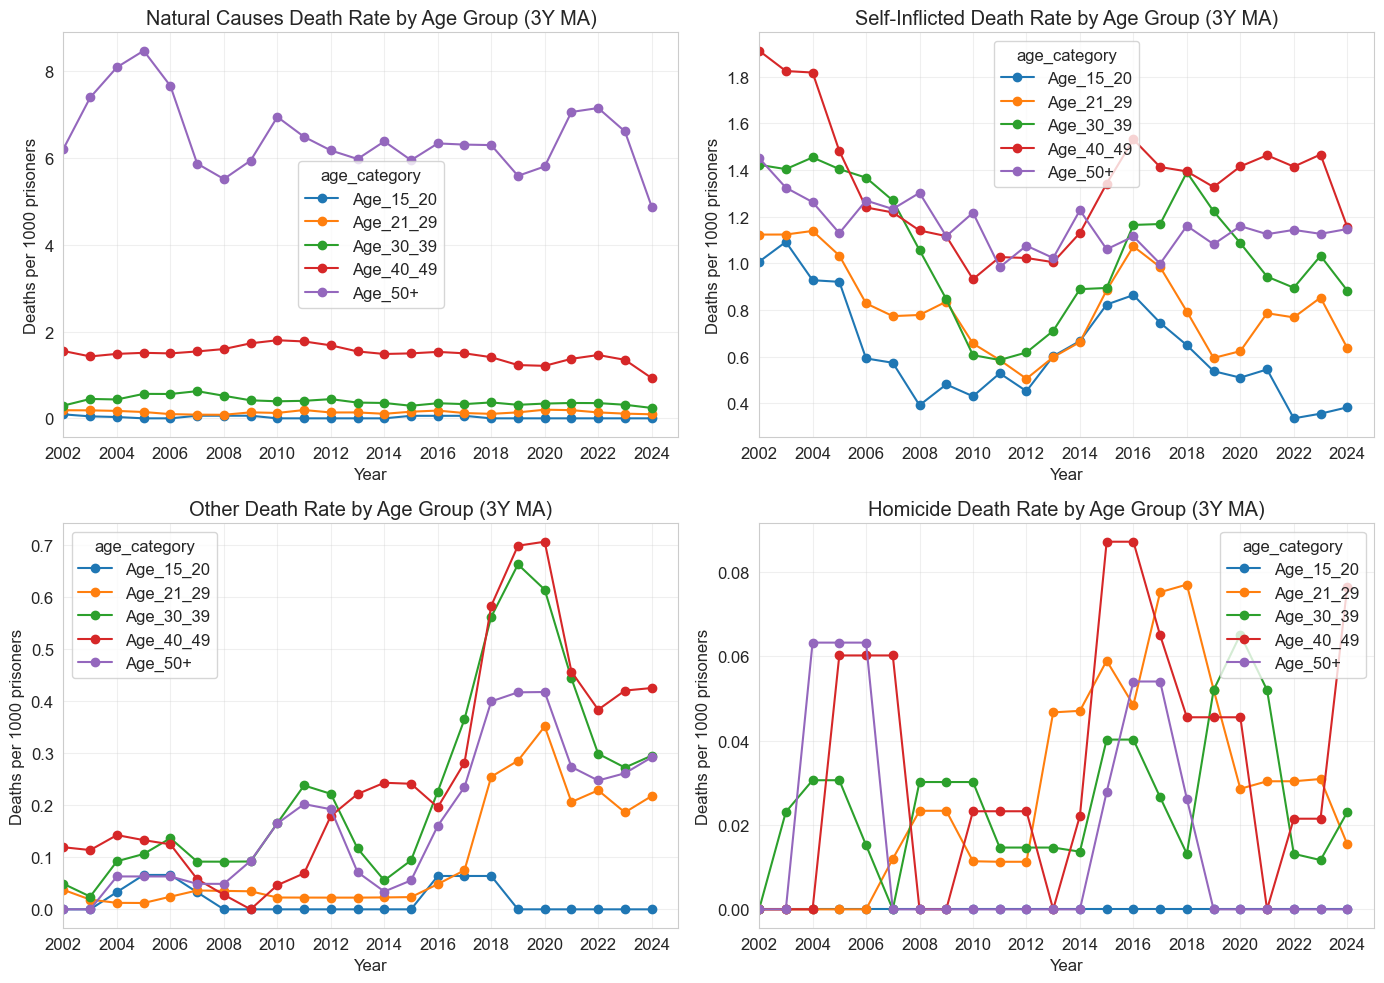

<Figure size 1000x600 with 0 Axes>

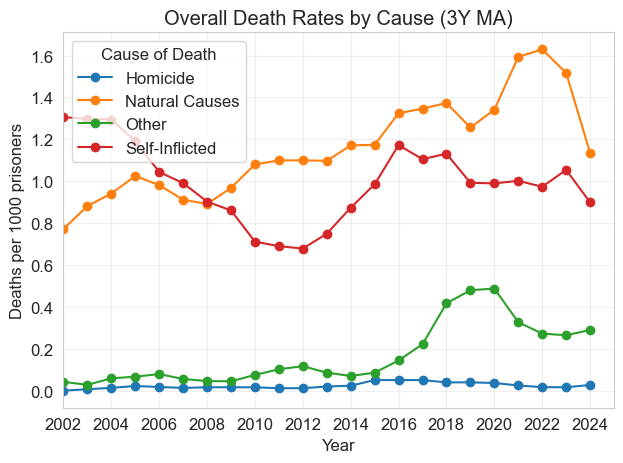

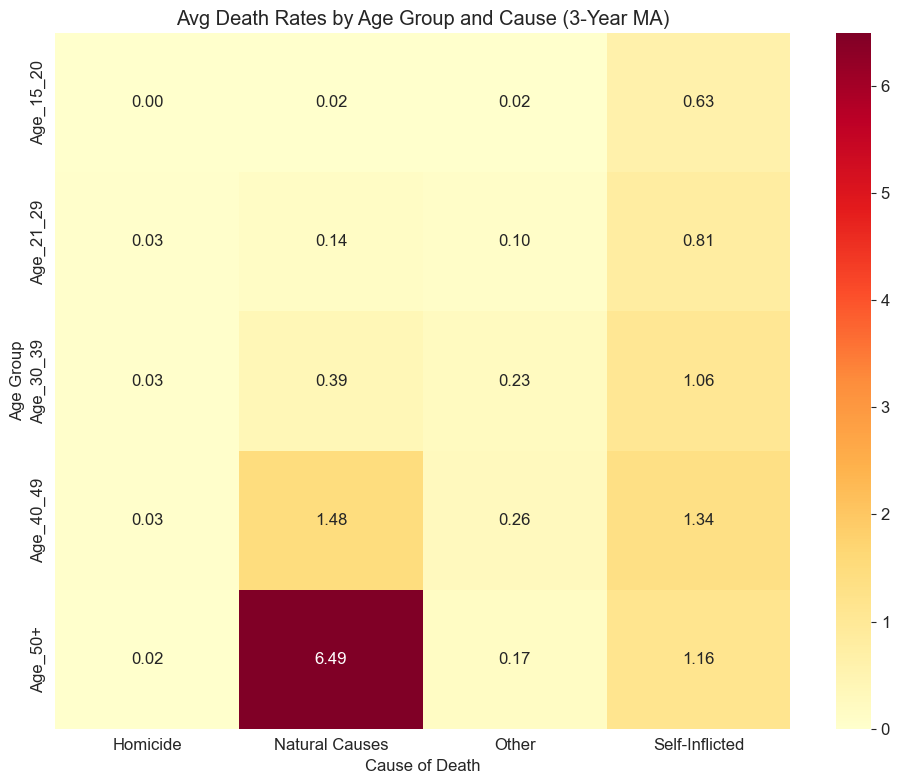

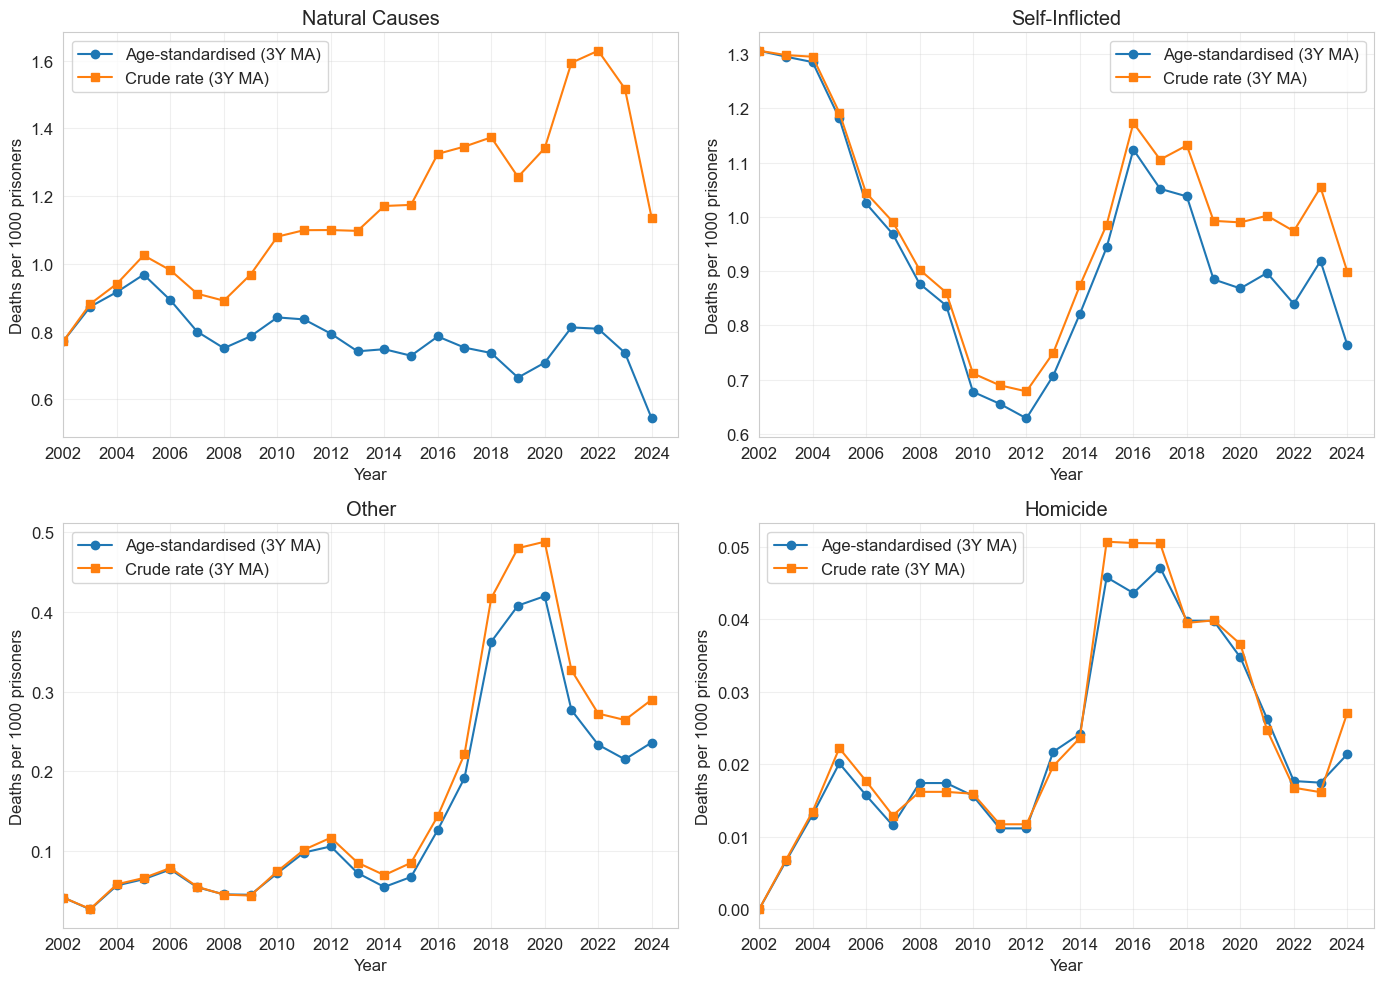

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -------- MOVING AVERAGE CALCULATION --------

# 3-year moving average for age-specific rates
smoothed_rates = age_specific_rates.copy()
smoothed_rates['rate_per_1000_ma'] = smoothed_rates.sort_values('year').groupby(
    ['age_category', 'cause_of_death']
)['rate_per_1000'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())

# 3-year moving average for overall crude rates
smoothed_overall = overall_rates.copy()
smoothed_overall['overall_rate_ma'] = smoothed_overall.sort_values('year').groupby(
    'cause_of_death'
)['overall_rate'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())

# 3-year moving average for standardized rates
smoothed_std = standardized_rates.copy()
smoothed_std['standardized_rate_ma'] = smoothed_std.sort_values('year').groupby(
    'cause_of_death'
)['standardized_rate'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())

# -------- CLIP AND SET AXIS RANGE --------

x_min, x_max = 2002, 2025
x_ticks = np.arange(x_min, x_max + 1, 2)

smoothed_rates_clipped = smoothed_rates[(smoothed_rates['year'] >= x_min) & (smoothed_rates['year'] <= 2024)]
smoothed_overall_clipped = smoothed_overall[(smoothed_overall['year'] >= x_min) & (smoothed_overall['year'] <= 2024)]
smoothed_std_clipped = smoothed_std[(smoothed_std['year'] >= x_min) & (smoothed_std['year'] <= 2024)]

# -------- 1. DEATH RATES BY AGE AND CAUSE --------

plt.figure(figsize=(14, 10))

for i, cause in enumerate(['Natural Causes', 'Self-Inflicted', 'Other', 'Homicide']):
    ax = plt.subplot(2, 2, i+1)
    cause_data = smoothed_rates_clipped[smoothed_rates_clipped['cause_of_death'] == cause]
    pivot_data = cause_data.pivot(index='year', columns='age_category', values='rate_per_1000_ma')
    pivot_data.plot(marker='o', ax=ax)
    ax.set_title(f'{cause} Death Rate by Age Group (3Y MA)')
    ax.set_ylabel('Deaths per 1000 prisoners')
    ax.set_xlabel('Year')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(x_min, x_max)
    ax.set_xticks(x_ticks)

plt.tight_layout()
plt.savefig('Output/Deaths/death_rates_by_age_cause_ma_clipped.png', dpi=300)

# -------- 2. OVERALL DEATH RATES BY CAUSE --------

plt.figure(figsize=(10, 6))
ax = smoothed_overall_clipped.pivot(index='year', columns='cause_of_death', values='overall_rate_ma').plot(marker='o')
ax.set_title('Overall Death Rates by Cause (3Y MA)')
ax.set_ylabel('Deaths per 1000 prisoners')
ax.set_xlabel('Year')
ax.grid(True, alpha=0.3)
ax.set_xlim(x_min, x_max)
ax.set_xticks(x_ticks)
plt.legend(title='Cause of Death')
plt.tight_layout()
plt.savefig('Output/Deaths/overall_death_rates_ma_clipped.png', dpi=300)

# -------- 3. HEATMAP (average of smoothed rates across years) --------

plt.figure(figsize=(10, 8))
avg_rates_ma = smoothed_rates_clipped.groupby(['age_category', 'cause_of_death'])['rate_per_1000_ma'].mean().reset_index()
heatmap_data_ma = avg_rates_ma.pivot(index='age_category', columns='cause_of_death', values='rate_per_1000_ma')

sns.heatmap(heatmap_data_ma, annot=True, fmt='.2f', cmap='YlOrRd')
plt.title('Avg Death Rates by Age Group and Cause (3-Year MA)')
plt.ylabel('Age Group')
plt.xlabel('Cause of Death')
plt.tight_layout()
plt.savefig('Output/Deaths/death_rates_heatmap_ma.png', dpi=300)

# -------- 4. STANDARDIZED VS CRUDE RATES --------

plt.figure(figsize=(14, 10))
for i, cause in enumerate(['Natural Causes', 'Self-Inflicted', 'Other', 'Homicide']):
    ax = plt.subplot(2, 2, i+1)
    std_data = smoothed_std_clipped[smoothed_std_clipped['cause_of_death'] == cause]
    crude_data = smoothed_overall_clipped[smoothed_overall_clipped['cause_of_death'] == cause]
    ax.plot(std_data['year'], std_data['standardized_rate_ma'], marker='o', label='Age-standardised (3Y MA)')
    ax.plot(crude_data['year'], crude_data['overall_rate_ma'], marker='s', label='Crude rate (3Y MA)')
    ax.set_title(f'{cause}')
    ax.set_ylabel('Deaths per 1000 prisoners')
    ax.set_xlabel('Year')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(x_min, x_max)
    ax.set_xticks(x_ticks)
    ax.legend()

plt.tight_layout()
plt.savefig('Output/Deaths/standardized_vs_crude_rates_ma_clipped.png', dpi=300)
